In [65]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import pandas as pd
import random

In [82]:
def P_r(r):
    P_r = P_t + 20 * np.log10(c / (4* np.pi* f* r))
    return P_r

Z = 2 # height of router - height of device

def chi_squared(Sis, x, y, routers=[], Z=2, sigma=1):
    chi = 0
    for i, (x_i, y_i) in enumerate(routers):
        S_i = Sis[i]
        r = math.sqrt((x - x_i)**2 + (y - y_i)**2 + Z**2)
        chi += ((P_r(r) - S_i)**2)/sigma**2
    return chi
    
def chi_squared_xy(xy):
    x,y = xy
    chi = chi_squared(Sis,x, y, routers)
    return chi

def calculate_S_is(S_x, S_y, routers, noise):
    Sis = []
    for (x_i, y_i) in routers:
        if noise:
            mu = 0
            sigma = noise
            package_noise = np.random.normal(mu, sigma, 1)[0]
        else:
            package_noise = 0
        S_r = math.sqrt((S_x - x_i)**2 + (S_y - y_i)**2 + Z**2)

        S_i = P_r(S_r) + package_noise
        Sis.append(S_i)
    return Sis
  
def triangulate(routers, signals):
    #print("TRIANGULATING!!!! WOOOO")
    pos = (random.randint(0,20), random.randint(0,20))
    uncertainty = (1,2)
    return pos, uncertainty

def plot_pos_uncertainty(pos, uncertainty, fig, ax):
    (x,y) = pos
    (width, height) = uncertainty
    ellipse = matplotlib.patches.Ellipse(pos, width, height, linewidth=1, fc='b', fill=True, alpha=0.3)
    ax.plot(x,y, 'o')
    plt.axis([0,20,0,20])
    ax.add_artist(ellipse)
    

In [83]:
#configuring the coordinates of the routers
named_routers = {
            "Lima": (5.82, 5.48),
            "Mike": (11.33, 9.43),
            "Kilo": (12.39, 6.77),
            "Oscar": (2.48, 7.36),
            "Alpha": (8.53, 2.16),
            "India": (2.18, 5.61),
            "November": (8.34, 4.13),
            "Hotel": (5.43, 4.71),
            "Romeo": (10.99, 5.94),
            "Quebec": (6.82, 9.78),
            "Papa": (9.9, 10.39)
          }

In [84]:
fname = 'UvA-wifitracking-exercise-prepped-data.csv'

df = pd.read_csv(fname)
packets = df.groupby(['typeNr', 'subTypeNr', 'seqNr'])


C:\Users\Celeste\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


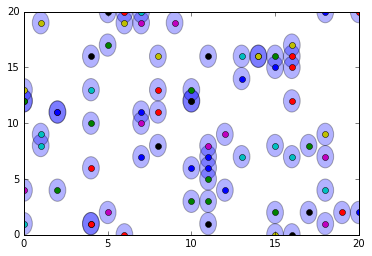

In [86]:
positions = []

#rebuild the routers list per packet
# routers = [(0,0), (0,20), (20,20), (20, 0)]


fig, ax = plt.subplots()
for packet in packets:
#     print(packet[1][['droneId', 'signal']])
#     print(type(packet[1]))
    routers = []
    signals = []
    for row in packet[1].iterrows():
        droneId = row[1].loc['droneId']
        signal =  row[1].loc['signal']
        routers.append(named_routers[droneId])
        signals.append(signal)
    #print(routers, signals)
    pos, uncertainty = triangulate(routers, signals) 
    plot_pos_uncertainty(pos, uncertainty, fig, ax)
fig.show()
    
        